In [5]:
from tif2pngs import Tif2Pngs, ROOT
import os

# 分割原始 tif 文件
infer_dir = os.path.join(ROOT, 'datasets', 'main', 'infer')
result_file_path = os.path.join(ROOT, 'datasets', 'main', 'result.tif')
tif2pngs = Tif2Pngs(result_file_path, os.path.join(infer_dir, 'images'), inference=True)
tif2pngs.process_tif()

ModuleNotFoundError: No module named 'code.eval'; 'code' is not a package

In [1]:
from tif2pngs import ROOT
import os
from segmentation_models_pytorch import Unet
import torch

model_path = os.path.join(ROOT, 'model', 'best_model_epoch_50.pth')
model_config = {
    'model': Unet,
    'encoder_name': 'resnet34',
    'classes': 3,
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model_config['model'](
    encoder_name=model_config['encoder_name'],
    classes=model_config['classes'],
).to(device)

model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
pass

In [2]:
from SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from torchvision import transforms as T

images_dir = os.path.join(ROOT, 'data', 'infer')

transform = T.Compose([
    T.ToTensor(),
])
infer_dataset = SegmentationDataset(root_dir=images_dir, transform=transform, inference=True)

In [3]:
import re
import numpy as np

images = infer_dataset.get_images()
max_x = 0
max_y = 0

for image in images:
    match = re.search(r'_(\d+)_(\d+)\.png', image)
    if match:
        x = int(match.group(1))
        y = int(match.group(2))
        if x > max_x:
            max_x = x
        if y > max_y:
            max_y = y

# 新建一个 ndarray
array = np.zeros((max_x + 256, max_y + 256), dtype=np.uint8)

In [10]:
import numpy as np
import re

with torch.no_grad():
    for input_image, image_name in infer_dataset:
        tmp = input_image.unsqueeze(0).to(device)
        output = model(tmp)
        result = output.squeeze().cpu().numpy()
        print(result.shape)
        result = np.argmax(result, axis=0)
        print(result.shape)
        # print(image_name)
        match = re.search(r'_(\d+)_(\d+)\.png', image_name)
        if match:
            x = int(match.group(1))
            y = int(match.group(2))
            array[x:x + 256, y:y + 256] = result
        else:
            print(f"Error: {image_name} does not match the pattern")

        # break

(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)
(3, 256, 256)
(256, 256)


KeyboardInterrupt: 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [7]:
import rasterio
result_file_path = os.path.join(ROOT, 'datasets', 'main', 'result.tif')
with rasterio.open(result_file_path) as src:
    meta = src.meta.copy()
    print(meta)


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 43641, 'height': 39291, 'count': 4, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]'), 'transform': Affine(0.0651, 0.0, 258121.02701859066,
       0.0, -0.0651, 4518292.6701675765)}


In [8]:
meta.update({
    'count': 1,
})

In [9]:
import time
output_path = os.path.join(ROOT, f'submission_{int(time.time())}.tif')

with rasterio.open(output_path, 'w', **meta) as dst:
    dst.write(array, 1)


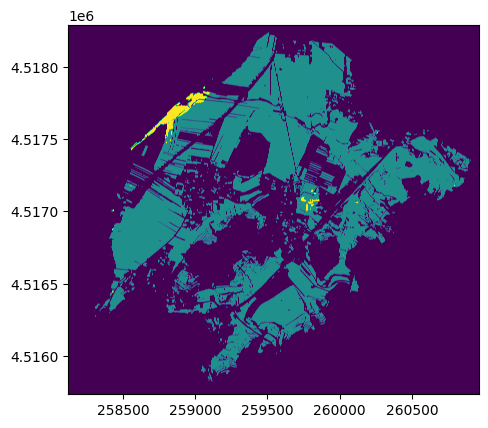

<Axes: >

In [11]:
from rasterio.plot import show

# 打开tif文件
ds_standard = rasterio.open(output_path)

show((ds_standard, 1))

In [15]:
from tif2pngs import ROOT
import os
from segmentation_models_pytorch import Unet
import torch

model_config = {
    'model': Unet,
    'encoder_name': 'densenet121',
    'classes': 3,
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model_config['model'](
    encoder_name=model_config['encoder_name'],
    classes=model_config['classes'],
).to(device)
pass

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to C:\Users\Vcore/.cache\torch\hub\checkpoints\densenet121-fbdb23505.pth
100%|██████████| 30.9M/30.9M [01:31<00:00, 355kB/s]


In [14]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
